In [35]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers, Model

from transformers import AutoTokenizer

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score
)

In [36]:
TRAIN_PATH = "../data/train_model.csv"
VAL_PATH   = "../data/val_model.csv"
TEST_PATH  = "../data/test_model.csv"

df_train = pd.read_csv(TRAIN_PATH)
df_val   = pd.read_csv(VAL_PATH)
df_test  = pd.read_csv(TEST_PATH)

X_train_text = df_train["clean_body"].fillna("").astype(str).tolist()
y_train      = df_train["rule_violation"].astype(int).values

X_val_text   = df_val["clean_body"].fillna("").astype(str).tolist()
y_val        = df_val["rule_violation"].astype(int).values  

In [37]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## Se carga GloVe

In [38]:
GLOVE_DIM = 100
GLOVE_PATH = "../glove/glove.6B.100d.txt"

print("Loading GloVe vectors...")
embeddings_index = {}

with open(GLOVE_PATH, "r", encoding="utf8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print("Loaded:", len(embeddings_index), "vectors")

Loading GloVe vectors...
Loaded: 400000 vectors


In [39]:
vocab = tokenizer.get_vocab()
vocab_size = len(vocab)

embedding_matrix = np.zeros((vocab_size, GLOVE_DIM))
unknowns = 0

for token, idx in vocab.items():

    # remover subword prefix "##"
    if token.startswith("##"):
        token_clean = token[2:]
    else:
        token_clean = token

    # usar minúsculas (GloVe es lowercase)
    token_clean = token_clean.lower()

    vector = embeddings_index.get(token_clean)

    if vector is not None:
        embedding_matrix[idx] = vector
    else:
        unknowns += 1

print(f"Embedding matrix created. Unknown tokens: {unknowns}/{vocab_size}")

Embedding matrix created. Unknown tokens: 3827/30522


In [40]:
def tokenize(texts, max_len=128):
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="np"
    )

X_train_tok = tokenize(X_train_text)
X_val_tok   = tokenize(X_val_text)

In [43]:
def attention_layer(inputs):
    score = layers.Dense(1, activation="tanh")(inputs)
    attention_weights = layers.Softmax(axis=1)(score)
    weighted = layers.Multiply()([inputs, attention_weights])
    context_vector = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted)
    return context_vector

In [44]:
MAX_LEN = 128

input_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")

x = layers.Embedding(
    input_dim=vocab_size,
    output_dim=GLOVE_DIM,
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=False
)(input_ids)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = attention_layer(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(1, activation="sigmoid")(x)

model = Model(inputs=input_ids, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 128, 100)  │  3,052,200 │ input_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 128, 256)  │    234,496 │ embedding_5[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128, 1)    │        257 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_5 (Softmax) │ (None, 128, 1)    │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 128, 256)  │          0 │ bidirectional_5[… │
│ (Multiply)          │                   │            │ softmax_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 256)       │          0 │ multiply_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     32,896 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,319,978 (12.66 MB)

 Trainable params: 267,778 (1.02 MB)

 Non-trainable params: 3,052,200 (11.64 MB)

In [45]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

history = model.fit(
    X_train_tok["input_ids"],
    y_train,
    validation_data=(X_val_tok["input_ids"], y_val),
    epochs=12,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.5699 - loss: 0.6750 - val_accuracy: 0.6084 - val_loss: 0.6629
Epoch 2/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.6229 - loss: 0.6552 - val_accuracy: 0.6232 - val_loss: 0.6405
Epoch 3/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.6426 - loss: 0.6114 - val_accuracy: 0.6576 - val_loss: 0.6002
Epoch 4/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.6753 - loss: 0.5814 - val_accuracy: 0.6182 - val_loss: 0.6290
Epoch 5/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.6845 - loss: 0.5753 - val_accuracy: 0.6749 - val_loss: 0.5887
Epoch 6/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.7036 - loss: 0.5644 - val_accuracy: 0.6847 - val_loss: 0.5816
Epoch 7/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.7240 - loss: 0.5352 - val_accuracy: 0.6847 - val_loss: 0.5713
Epoch 8/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.7246 - loss: 0.5499 - val_accuracy: 0.692

In [46]:
y_pred_prob = model.predict(X_val_tok["input_ids"]).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

acc = accuracy_score(y_val, y_pred)
f1  = f1_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred).tolist()

try:
    auc = roc_auc_score(y_val, y_pred_prob)
except:
    auc = None

print("\n=== METRICS ===")
print("Acc:", acc)
print("F1:", f1)
print("Precision:", prec)
print("Recall:", rec)
print("AUC:", auc)
print("Confusion matrix:", cm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step

=== METRICS ===
Acc: 0.6847290640394089
F1: 0.7217391304347827
Precision: 0.6535433070866141
Recall: 0.8058252427184466
AUC: 0.7739199029126214
Confusion matrix: [[112, 88], [40, 166]]


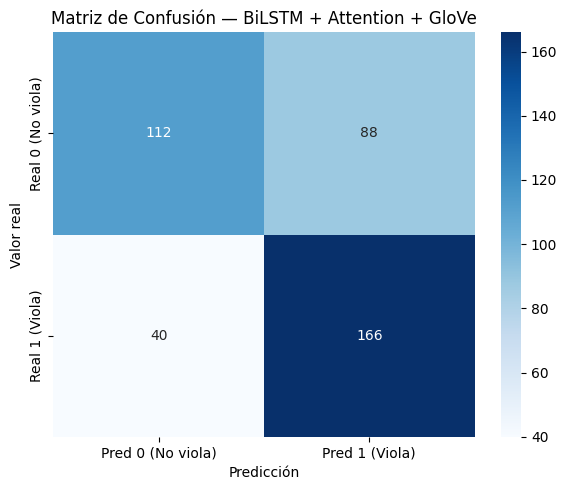

In [55]:
# %% [markdown]
# ## Matriz de Confusión

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0 (No viola)", "Pred 1 (Viola)"],
    yticklabels=["Real 0 (No viola)", "Real 1 (Viola)"]
)
plt.title("Matriz de Confusión — BiLSTM + Attention + GloVe")
plt.ylabel("Valor real")
plt.xlabel("Predicción")
plt.tight_layout()
plt.show()


In [47]:
models_dir = Path("../models/models_bilstm")
models_dir.mkdir(exist_ok=True, parents=True)

model.save(models_dir / "bilstm_attention_model.keras")
tokenizer.save_pretrained(models_dir / "tokenizer")

meta = {
    "name": "BiLSTM_Attention",
    "type": "tensorflow",
    "path": "bilstm_attention_model",
    "description": "Neural network with BiLSTM + Attention + EarlyStopping",
    "metrics": {
        "accuracy": float(acc),
        "f1": float(f1),
        "precision": float(prec),
        "recall": float(rec),
        "auc": float(auc) if auc else None,
        "confusion_matrix": cm,
        "n_val": len(y_val)
    }
}

with open(models_dir / "metadata.json", "w", encoding="utf8") as f:
    json.dump(meta, f, indent=2)

print("Model + tokenizer + metadata saved.")

Model + tokenizer + metadata saved.


In [52]:
def predict_text(text):
    tokens = tokenizer(
        [text],
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="np"
    )
    prob = model.predict(tokens["input_ids"])[0][0]
    pred = int(prob >= 0.5)
    return prob, pred

text = "Nice"
prob, pred = predict_text(text)
print(f"Prediciendo: '{text}'")
print("Probabilidad:", prob)
print("Predicción:", pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediciendo: 'Nice'
Probabilidad: 0.3171124
Predicción: 0
